In [1]:
import tensorflow as tf
import math
from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset
import os

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' #suppress logging messages
tf.logging.set_verbosity(tf.logging.ERROR) #suppress logging messages
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format 
#whatever the value and .1f tells to format it upto one decimal place

In [3]:
california_housing_dataframe = pd.read_csv("https://storage.googleapis.com/mledu-datasets/california_housing_train.csv", sep=",")

In [4]:
#we will randomize the dataset by np.random.permutation(california_housing_dataframe.index)
#so that the Stochastic Gradient Descent works fine without any pathological ordering effects
california_housing_dataframe = california_housing_dataframe.reindex(np.random.permutation(california_housing_dataframe.index))
california_housing_dataframe["median_house_value"] /= 1000.0

#get to know your data, statistical data
#print(california_housing_dataframe.describe())

In [5]:
# describe feature and feature column
# feature column is just a column that indicates a feature's data type

# input feature
my_feature = california_housing_dataframe[["total_rooms"]]

#feature column
feature_column = [tf.feature_column.numeric_column("total_rooms")]

#Defining label
target = california_housing_dataframe["median_house_value"]

In [6]:
#Configure a linear Regressor (linear regression model optimizer)
# clip_gradients_by_norm (ensures mag of gradient does not become too large)

#optimizer
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.0000001)
optimizer = tf.contrib.estimator.clip_gradients_by_norm(optimizer, 5.0)

#Configure a linear regression model
linear_regression = tf.estimator.LinearRegressor(
	feature_columns = feature_column,
	optimizer= optimizer
	)

In [7]:
# Define and Input Function:
# To import our data into our Linear Regressor, we need to define 
# an input funciton, which tells Tensorflow how to preprocess the data
# or to shuffle, batch and repeat it during model training
def my_input_func(features,targets,batch_size=1, shuffle=True, num_epochs=None):

	"""Trains a linear regression model of one feature.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    # Convert pandas data into a dict of np arrays
	features = {key:np.array(value) for key, value in dict(features).items()}

	# Construct a dataset API (tensorflow), and configure batching/repeating
	ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
	ds = ds.batch(batch_size).repeat(num_epochs)

    #shuffle the data, if specified
	if shuffle:
		ds = ds.shuffle(buffer_size= 10000)

    #Return the next batch of data
	features,labels = ds.make_one_shot_iterator().get_next()
	return features,labels

In [8]:
#input given to the tensorflow linear regression optimizer that we built above 
input_f = lambda:my_input_func(my_feature,target)
train = linear_regression.train(input_fn=input_f,steps=100)


In [9]:
# Create an input function for predictions.
# Note: Since we're making just one prediction for each example, we don't 
# need to repeat or shuffle the data here.
predictions_input = lambda:my_input_func(my_feature,target,num_epochs=1,shuffle=False)

# Call predict() on the linear_regressor to make predictions.
predictions = linear_regression.predict(input_fn = predictions_input)

# Format predictions as a NumPy array, so we can calculate error metrics.
predictions = np.array([item['predictions'][0] for item in predictions])

# Print Mean Squared Error and Root Mean Squared Error.
mean_squared_error = metrics.mean_squared_error(predictions, target)
root_mean_squared_error = math.sqrt(mean_squared_error)
print("Mean Squared Error (on training data): %0.3f" % mean_squared_error)
print("Root Mean Squared Error (on training data): %0.3f" % root_mean_squared_error)

Mean Squared Error (on training data): 56367.025
Root Mean Squared Error (on training data): 237.417


In [10]:
#How would we judge the value we get from the RMSE and MSE?
#Compare it to the difference of min and max values of our target

min_house_value = california_housing_dataframe["median_house_value"].min()
max_house_value = california_housing_dataframe["median_house_value"].max()
min_max_diff = max_house_value-min_house_value

print ("Min. Median House Value: %0.3f" % min_house_value)
print ("Max. Median House Value: %0.3f" % max_house_value)
print ("Difference between Min. and Max.: %0.3f" % min_max_diff)
print ("Root Mean Squared Error: %0.3f" % root_mean_squared_error)

Min. Median House Value: 14.999
Max. Median House Value: 500.001
Difference between Min. and Max.: 485.002
Root Mean Squared Error: 237.417


In [11]:
calibration_data = pd.DataFrame()
calibration_data["predictions"] = pd.Series(predictions)
calibration_data["target"] = pd.Series(target)
calibration_data.describe()

,predictions,target
count,17000.0,17000.0
mean,0.1,207.3
std,0.1,116.0
min,0.0,15.0
25%,0.1,119.4
50%,0.1,180.4
75%,0.2,265.0
max,1.9,500.0


In [12]:
# to make a readable scatter plot
sample = california_housing_dataframe.sample(n=300)

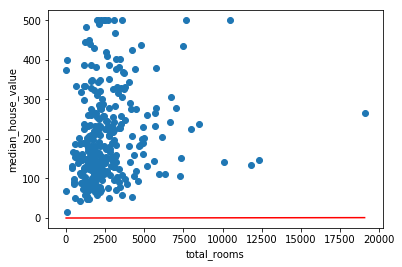

In [21]:
# Get the min and max total_rooms values.
x_0 = sample["total_rooms"].min()
x_1 = sample["total_rooms"].max()

# Retrieve the final weight and bias generated during training.
weight = linear_regression.get_variable_value('linear/linear_model/total_rooms/weights')[0]
bias = linear_regression.get_variable_value('linear/linear_model/bias_weights')

# Get the predicted median_house_values for the min and max total_rooms values.
y_0 = weight * x_0 + bias 
y_1 = weight * x_1 + bias

# Plot our regression line from (x_0, y_0) to (x_1, y_1).
plt.plot([x_0, x_1], [y_0, y_1], c='r')

# Label the graph axes.
plt.ylabel("median_house_value")
plt.xlabel("total_rooms")

# Plot a scatter plot from our data sample.
plt.scatter(sample["total_rooms"], sample["median_house_value"])

# Display graph.
plt.show()

In [13]:
# make a single train_model function for the above process with numerous periods 
# Hyperparamters tweaking

def train_model(learning_rate,steps,batch_size,input_feature="total_rooms"):
    
    """Trains a linear regression model of one feature.
  
      Args:
        learning_rate: A `float`, the learning rate.
        steps: A non-zero `int`, the total number of training steps. A training step
          consists of a forward and backward pass using a single batch.
        batch_size: A non-zero `int`, the batch size.
        input_feature: A `string` specifying a column from `california_housing_dataframe`
          to use as input feature.
          
          In this function, we'll proceed in 10 evenly divided periods so that we can observe the model improvement at each period.
          For each period, we'll compute and graph training loss. This may help you judge when a model is converged, or if it needs more iterations.
    """
    periods = 10
    step_period = steps/periods
    my_feature = input_feature
    my_feature_data = california_housing_dataframe[[my_feature]]
    target_data = california_housing_dataframe["median_house_value"]
    
    #Create column feature
    feature_column = [tf.feature_column.numeric_column(my_feature)]
    
    #Create input function
    training_input= lambda:my_input_func(my_feature_data, target_data, batch_size=batch_size)
    prediction_input = lambda: my_input_func(my_feature_data, target_data, num_epochs=1, shuffle=False)
    
    # create a linear regressor optimizer
    my_opt = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    my_opt = tf.contrib.estimator.clip_gradients_by_norm(my_opt,5.0)
    linear_regressor = tf.estimator.LinearRegressor(feature_columns = feature_column, optimizer = my_opt)
   
    # Set up to plot the state of our model's line each period.
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plt.title("Learned Line by Period")
    plt.ylabel("median_house_value")
    plt.xlabel(my_feature)
    sample = california_housing_dataframe.sample(n=300)
    plt.scatter(sample[my_feature], sample["median_house_value"])
    colors = [cm.coolwarm(x) for x in np.linspace(-1, 1, periods)]
    
    #Train the model, but have to do in a loop of periods so we can 
    #see the change in the RMSE
    print("Training  model...")
    print("RMSE (on training data)")
    root_mean_squared_errors = [] #This will have all the RMSE of the periods
    for period in range(0,periods):
        linear_regressor.train(input_fn=training_input,steps=step_period)
        
        #Compute predictions
        predictions = linear_regressor.predict(input_fn=prediction_input)
        predictions = np.array([item['predictions'][0] for item in predictions])
        
        #Compute loss
        root_mean_square_error = math.sqrt(metrics.mean_squared_error(predictions,target_data))
        
        # Occasionally print the current loss.
        print ("  period %02d : %0.2f" % (period, root_mean_square_error))
        
        root_mean_squared_errors.append(root_mean_square_error)
        
        # Finally, track the weights and biases over time.
        # Apply some math to ensure that the data and line are plotted neatly.
        y_extents = np.array([0, sample["median_house_value"].max()])
        
        weight = linear_regressor.get_variable_value('linear/linear_model/%s/weights' % input_feature)[0]
        bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')
        
        x_extents = (y_extents - bias) / weight
        
        x_extents = np.maximum(np.minimum(x_extents,sample[my_feature].max()),sample[my_feature].min())
        y_extents = weight * x_extents + bias #linear regression line
        plt.plot(x_extents, y_extents, color=colors[period])
    
    print("Model training finished.")
    
    # Output a graph of loss metrics over periods.
    plt.subplot(1, 2, 2)
    plt.ylabel('RMSE')
    plt.xlabel('Periods')
    plt.title("Root Mean Squared Error vs. Periods")
    plt.tight_layout()
    plt.plot(root_mean_squared_errors)
    
    # Output a table with calibration data.
    calibration_data = pd.DataFrame()
    calibration_data["predictions"] = pd.Series(predictions)
    calibration_data["targets"] = pd.Series(target_data)
    display.display(calibration_data.describe())
    
    print("Final RMSE (on training data): %0.2f" % root_mean_square_error)

Training  model...
RMSE (on training data)
  period 00 : 229.13
  period 01 : 221.05
  period 02 : 213.34
  period 03 : 206.04
  period 04 : 199.20
  period 05 : 192.86
  period 06 : 187.07
  period 07 : 181.89
  period 08 : 177.38
  period 09 : 173.57
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,92.5,207.3
std,76.3,116.0
min,0.1,15.0
25%,51.2,119.4
50%,74.4,180.4
75%,110.3,265.0
max,1327.8,500.0


Final RMSE (on training data): 173.57


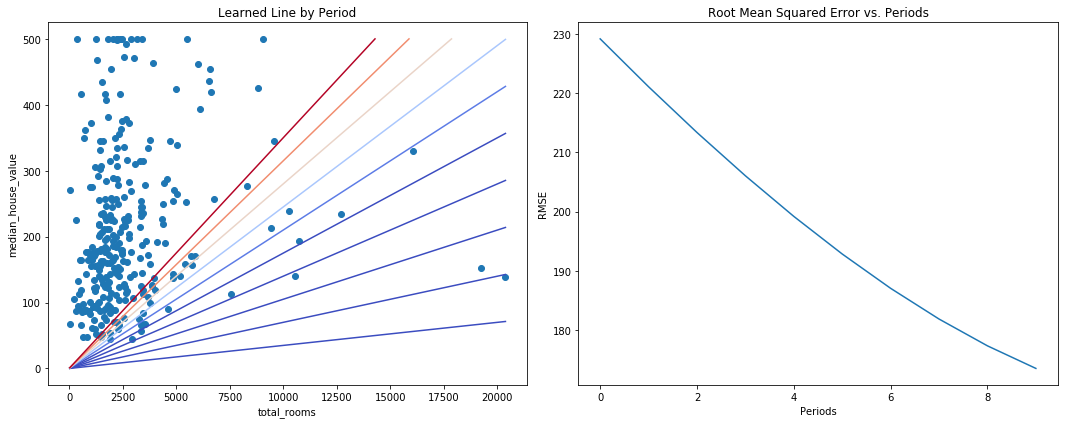

In [14]:
train_model(
    learning_rate=0.00007,
    steps=100,
    batch_size=100
)

In [15]:
# That said, here are a few rules of thumb that may help guide you:
# 1 Training error should steadily decrease, steeply at first, and should eventually plateau as training converges.
# 2 If the training has not converged, try running it for longer.
# 3 If the training error decreases too slowly, increasing the learning rate may help it decrease faster.
#         But sometimes the exact opposite may happen if the learning rate is too high.
#     If the training error varies wildly, try decreasing the learning rate.
#         Lower learning rate plus larger number of steps or larger batch size is often a good combination.
# Very small batch sizes can also cause instability. First try larger values like 100 or 1000, and decrease until you see degradation.


# Again, never go strictly by these rules of thumb, because the effects are data dependent. Always experiment and verify.